In [2]:
import numpy as np
from matplotlib import pyplot as plt

In [3]:
def swiss_roll(n):
    """
    Parameters:
    n: int
        Number of points to generate"""
    
    data = np.zeros((n,3))
    phi = np.random.uniform(low=1.5*np.pi, high=4.5*np.pi, size=n)
    psi = np.random.uniform(0,10,n)
            
    data[:,0]=phi*np.cos(phi) #x coordinte
    data[:,1]=phi*np.sin(phi) #y coordinate
    data[:,2]=psi #z coordinate
    return data

<class 'matplotlib.axes._subplots.Axes3DSubplot'>


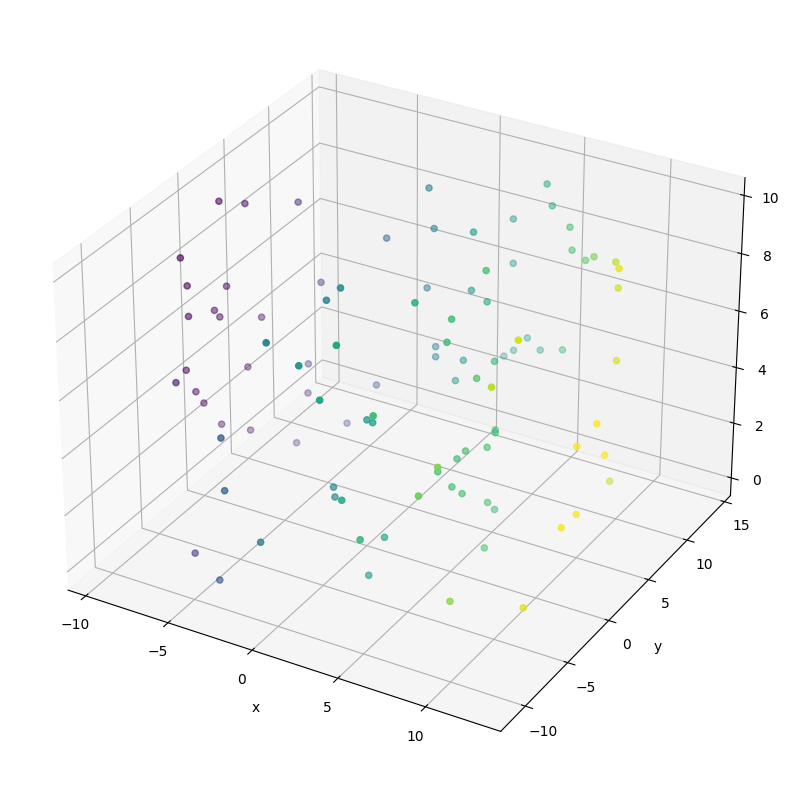

In [5]:
N = 100
X = swiss_roll(N)

plt.figure(figsize=(12,10))
axes = plt.axes(projection='3d')
print(type(axes))
axes.scatter3D(X[:,0], X[:,1], X[:,2], c=X[:,0])

axes.set_xlabel('x')
axes.set_ylabel('y')
axes.set_zlabel('z')

#axes.view_init(45, 45) #(elevation, azimuth angle)

plt.show()

In [6]:
print(X)
print(X.shape)

[[  2.49662846  -4.57504664   0.06404337]
 [  3.06837803 -10.84559329   7.94973302]
 [ -8.63617788   2.87800431   1.21091789]
 [  2.84838883  13.63695477   3.71152846]
 [  6.3377016    1.53347586   3.59748304]
 [ -6.5355556    5.74771524   3.22666174]
 [ -5.57120113  -8.82001113   0.56081315]
 [  5.53966213   4.1590971    3.26022301]
 [  5.4669391    4.28866557   3.31266156]
 [  6.35309206   1.30580733   0.08175772]
 [  5.78505701  -1.62591333   8.72817516]
 [ 11.15895978   6.90052311   6.03642708]
 [  2.44507668  -4.59125938   5.51569056]
 [  3.26925473  -4.25676968   1.47236314]
 [ 11.10347914  -4.92950604   9.75639711]
 [ 12.48240966   2.76056263   4.08405498]
 [  6.31715366   0.24461171   6.33034055]
 [  2.67429633   6.99503263   7.04178644]
 [  7.89603837  10.96617523   8.07090088]
 [ 12.59906071   1.41321746   5.54927778]
 [ -0.40010871   7.89448768   6.40840887]
 [  5.82087744  -1.54815281   2.95893081]
 [  0.03005083   7.85009605   8.55484144]
 [  7.15496975  11.54498813   7.68

In [7]:
from scipy.spatial.distance import pdist, squareform

sq_dists = pdist(X, "sqeuclidean")
print(sq_dists)
print(sq_dists.shape)

# Convert pairwise distances into a square distances-matrix
mat_sq_dists = squareform(sq_dists)
print(mat_sq_dists)
print(mat_sq_dists.shape)

[1.01830754e+02 1.80802667e+02 3.45104878e+02 ... 2.92440702e-01
 1.37382668e+01 1.59071271e+01]
(4950,)
[[0.00000000e+00 1.01830754e+02 1.80802667e+02 ... 2.01535178e+02
  2.00399578e+02 2.61946200e+02]
 [1.01830754e+02 0.00000000e+00 3.70745390e+02 ... 2.86934179e+02
  2.96172597e+02 2.96799888e+02]
 [1.80802667e+02 3.70745390e+02 0.00000000e+00 ... 2.91207036e+01
  2.41576023e+01 7.49840070e+01]
 ...
 [2.01535178e+02 2.86934179e+02 2.91207036e+01 ... 0.00000000e+00
  2.92440702e-01 1.37382668e+01]
 [2.00399578e+02 2.96172597e+02 2.41576023e+01 ... 2.92440702e-01
  0.00000000e+00 1.59071271e+01]
 [2.61946200e+02 2.96799888e+02 7.49840070e+01 ... 1.37382668e+01
  1.59071271e+01 0.00000000e+00]]
(100, 100)


In [15]:


from math import inf

def isomap(X):
    # threshold (circle)

    sq_dists = pdist(X, "sqeuclidean")

    Z = squareform(sq_dists)

    n_nodes = Z.shape[0]

    t = 10 # threshold

    for i in range(n_nodes):
        for j in range(n_nodes):
            if i != j:
                if Z[i][j] > t:
                    Z[i][j] = inf


    for i in range(n_nodes):
        for j in range(n_nodes):
            if i != j and Z[i][j]== 0:
                Z[i][j] = inf
            
    for k in range(n_nodes):
        for i in range(n_nodes):
            for j in range(n_nodes):
                if Z[i][j]>Z[i][k] +Z[k][j]:
                    Z[i][j] = Z[i][k] + Z[k][j]
    return Z

D = isomap(X)

In [16]:
G = np.empty([N,N])

D_sq = G**2
for i in range(N):
    for l in range(N):
        for k in range(N):
            sum_l = 0
            sum_i = 0
            sum_i += D[i][k]**2
            sum_l += D[k][l]**2
        G[i][l] = (1/2) * ((1/N) * (sum_i + sum_l) - 1/(N**2) * (np.sum(D_sq)) - D[i][l]**2)


/var/folders/m2/r059lv3n7nq9x6gh78v25xk80000gn/T/ipykernel_7369/1476764964.py:3: RuntimeWarning: overflow encountered in square
  D_sq = G**2


In [13]:
#skip
eig_vals, eig_vecs = np.linalg.eig(G)
print(np.all(np.linalg.eigvals(G) > 0))

sorted_indices = np.argsort(eig_vals)[::-1]
sorted_eigvecs = eig_vecs[:,sorted_indices]

top_2_eigvecs = sorted_eigvecs[:2]
ddiag = np.sqrt(np.diag(eig_vals[:2]))

pp = top_2_eigvecs.dot(ddiag)



print(top_2_eigvecs)
#first_comp = [top_2_eigvecs[i][0] for i in range(X.shape[0])]
#second_comp = [top_2_eigvecs[i][1] for i in range(X.shape[0])]

LinAlgError: Array must not contain infs or NaNs

In [17]:
J = np.eye(N)- 1/N * np.dot(np.ones(N),np.ones(N).T)
Gdelta = -1/2 * (J.dot(D)).dot(J)

eigval, eigvec = np.linalg.eig(Gdelta)

eigval[eigval<0] =0

sortedindices = np.argsort(eigval)[::-1]
sortedeigvecs = eigvec[:,sortedindices]

proj = sortedeigvecs[:2,]


first_comp = [proj[0][i] for i in range(N)]
second_comp = [proj[1][i] for i in range(N)]

plt.scatter(first_comp, second_comp, c =  X[:,0] )



LinAlgError: Array must not contain infs or NaNs

In [11]:
x = eigvec.T.dot(np.diag(np.sqrt(eigval)))

x.shape

(500, 500)